In [ ]:
import os, sys
sys.version

'3.6.9 (default, Jul 17 2020, 12:50:27) \n[GCC 8.4.0]'

# Imports

In [ ]:
import wave
import numpy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from numpy.fft import fft, rfft
from scipy.interpolate import interp1d
from scipy.signal      import argrelextrema
import glob, os, sys
import scipy.signal as sg
from scipy import signal
from scipy.signal import minimum_phase
from scipy.signal import hilbert, chirp
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Basic Functions

In [ ]:
def get_audio_file(path, nb_samples_factor=1):
  ifile = wave.open(path)
  samples = ifile.getnframes() * nb_samples_factor
  frequency = ifile.getframerate()
  audio = ifile.readframes(samples)

  # Convert buffer to float32 using NumPy                                                                                 
  audio_as_np_int16 = numpy.frombuffer(audio, dtype=numpy.int16)
  audio_as_np_float32 = audio_as_np_int16.astype(numpy.float32)

  # Normalise float32 array so that values are between -1.0 and +1.0                                                      
  max_int16 = 2**15

  time = [i/frequency for i in range(samples)]
  audio_normalised = audio_as_np_float32 / max_int16
  audio_normalised = audio_normalised / max(audio_normalised)

  return time, audio_normalised


In [ ]:
#https://stackoverflow.com/questions/34235530/python-how-to-get-high-and-low-envelope-of-a-signal
def hl_envelopes_idx(s,dmin=3,dmax=4):
    """
    Input :
    s : 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax : int, size of chunks, use this if size of data is too big
    Output :
    lmin,lmax : high/low enveloppe idx of signal s
    """

    # locals min      
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 
    
    
    """# using the following might help in some case by cutting the signal in "half"
    s_mid = np.mean(s)
    # pre-sorting of locals min based on sign 
    lmin = lmin[s[lmin]<s_mid]
    # pre-sorting of local max based on sign 
    lmax = lmax[s[lmax]>s_mid]"""
    

    # global max of dmax-chunks of locals max 
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global min of dmin-chunks of locals min 
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    
    return lmin,lmax

In [ ]:
def autocorrellation(x):
    result = sg.correlate(x, x, mode='full', method="fft")
    return result

In [ ]:
def real_dft(x):
    return np.fft.rfft(x)

In [ ]:
def normalized_autocor(x):
  a = autocorrellation(x)
  a = a[len(a)//2:]
  a /= a[0]
  return a

In [ ]:
def get_envelopes_interpolated(a):
  low_enveloppe, high_enveloppe = hl_envelopes_idx(a)
  low_enveloppe = interp1d(np.array(time)[low_enveloppe], a[low_enveloppe], kind="cubic", fill_value="extrapolate")
  high_enveloppe = interp1d(np.array(time)[high_enveloppe], a[high_enveloppe], kind="cubic", fill_value="extrapolate")
  return low_enveloppe, high_enveloppe


In [ ]:
def threshold(array, limit=0.07):
  a = np.array(array, copy=True)  
  a[a >= limit] = 1
  a[a <  limit] = 0
  return a

# Processing with one file 

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)


Text(0, 0.5, 'Amplitude')

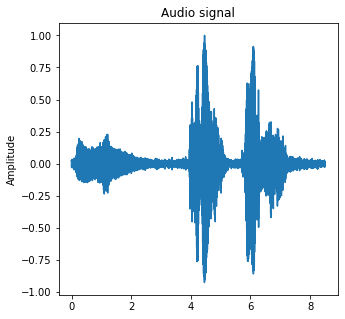

In [ ]:
time, audio = get_audio_file("/content/drive/My Drive/experiments_AURA/audio_002.wav", 2)
plt.plot(time, audio)
plt.title('Audio signal')
plt.ylabel('Amplitude')


In [ ]:
#sos = signal.butter(30, 100, 'hp', fs=frequency, output='sos')
#audio_normalised = signal.sosfilt(sos, audio_normalised)


Text(0, 0.5, 'Amplitude')

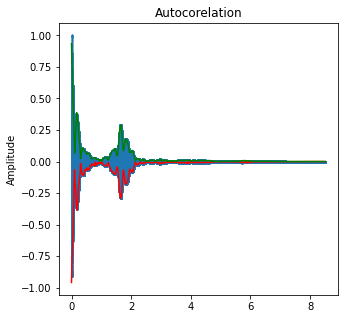

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)

autocorr = normalized_autocor(audio)
low_enveloppe, high_enveloppe = get_envelopes_interpolated(autocorr)

plt.scatter(time[:len(autocorr)], autocorr, s=1)
plt.plot(np.array(time), low_enveloppe(time), label='nearest', color='red')
plt.plot(np.array(time), high_enveloppe(time), label='nearest', color='green')
plt.title('Autocorelation')
plt.ylabel('Amplitude')


Text(0, 0.5, 'Amplitude')

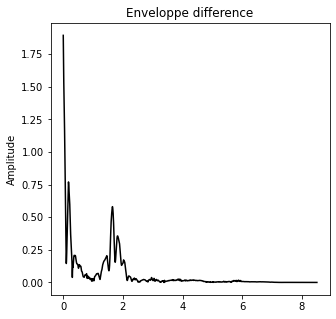

In [ ]:
env_diff = high_enveloppe(time)-low_enveloppe(time)

plt.plot(time, env_diff, label='nearest', color='black')
plt.title('Enveloppe difference')
plt.ylabel('Amplitude')


## Other envelope detector

In [ ]:
#f2 = interp1d(time[:len(a)], amplitude_envelope, kind='cubic')
#peaks, _ = find_peaks(amplitude_envelope, prominence=1)
"""analytic_signal = hilbert(amplitude_envelope)
amplitude_envelope = np.abs(analytic_signal)"""

"""low_enveloppe, high_enveloppe = hl_envelopes_idx(a)
low_enveloppe = interp1d(np.array(time)[low_enveloppe], a[low_enveloppe], kind="cubic", fill_value="extrapolate")
high_enveloppe = interp1d(np.array(time)[high_enveloppe], a[high_enveloppe], kind="cubic", fill_value="extrapolate")"""


'low_enveloppe, high_enveloppe = hl_envelopes_idx(a)\nlow_enveloppe = interp1d(np.array(time)[low_enveloppe], a[low_enveloppe], kind="cubic", fill_value="extrapolate")\nhigh_enveloppe = interp1d(np.array(time)[high_enveloppe], a[high_enveloppe], kind="cubic", fill_value="extrapolate")'

Text(0, 0.5, 'Amplitude')

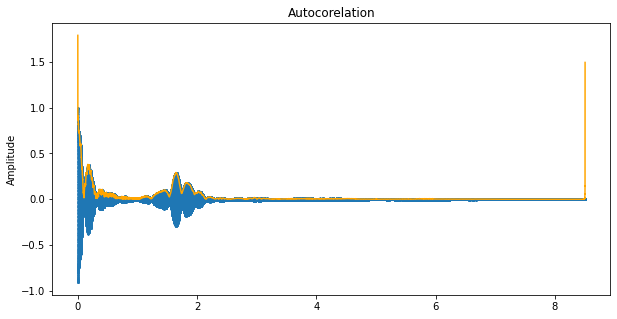

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)

autocorr = normalized_autocor(audio)
analytic_signal = hilbert(autocorr)
amplitude_envelope = np.abs(analytic_signal)

plt.scatter(time[:len(autocorr)], autocorr, s=1)
plt.plot(np.array(time[:len(autocorr)]), amplitude_envelope, color="orange")
plt.title('Autocorelation')
plt.ylabel('Amplitude')


Text(0, 0.5, 'Amplitude')

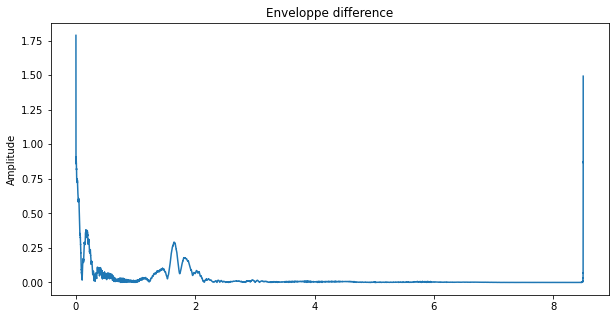

In [ ]:
plt.plot(np.array(time[:len(autocorr)]), amplitude_envelope)
plt.title('Enveloppe difference')
plt.ylabel('Amplitude')


# Processing of all audios

In [ ]:
files = [f"/content/drive/My Drive/experiments_AURA/audio_{i:03d}.wav" for i in range(2, 21)]


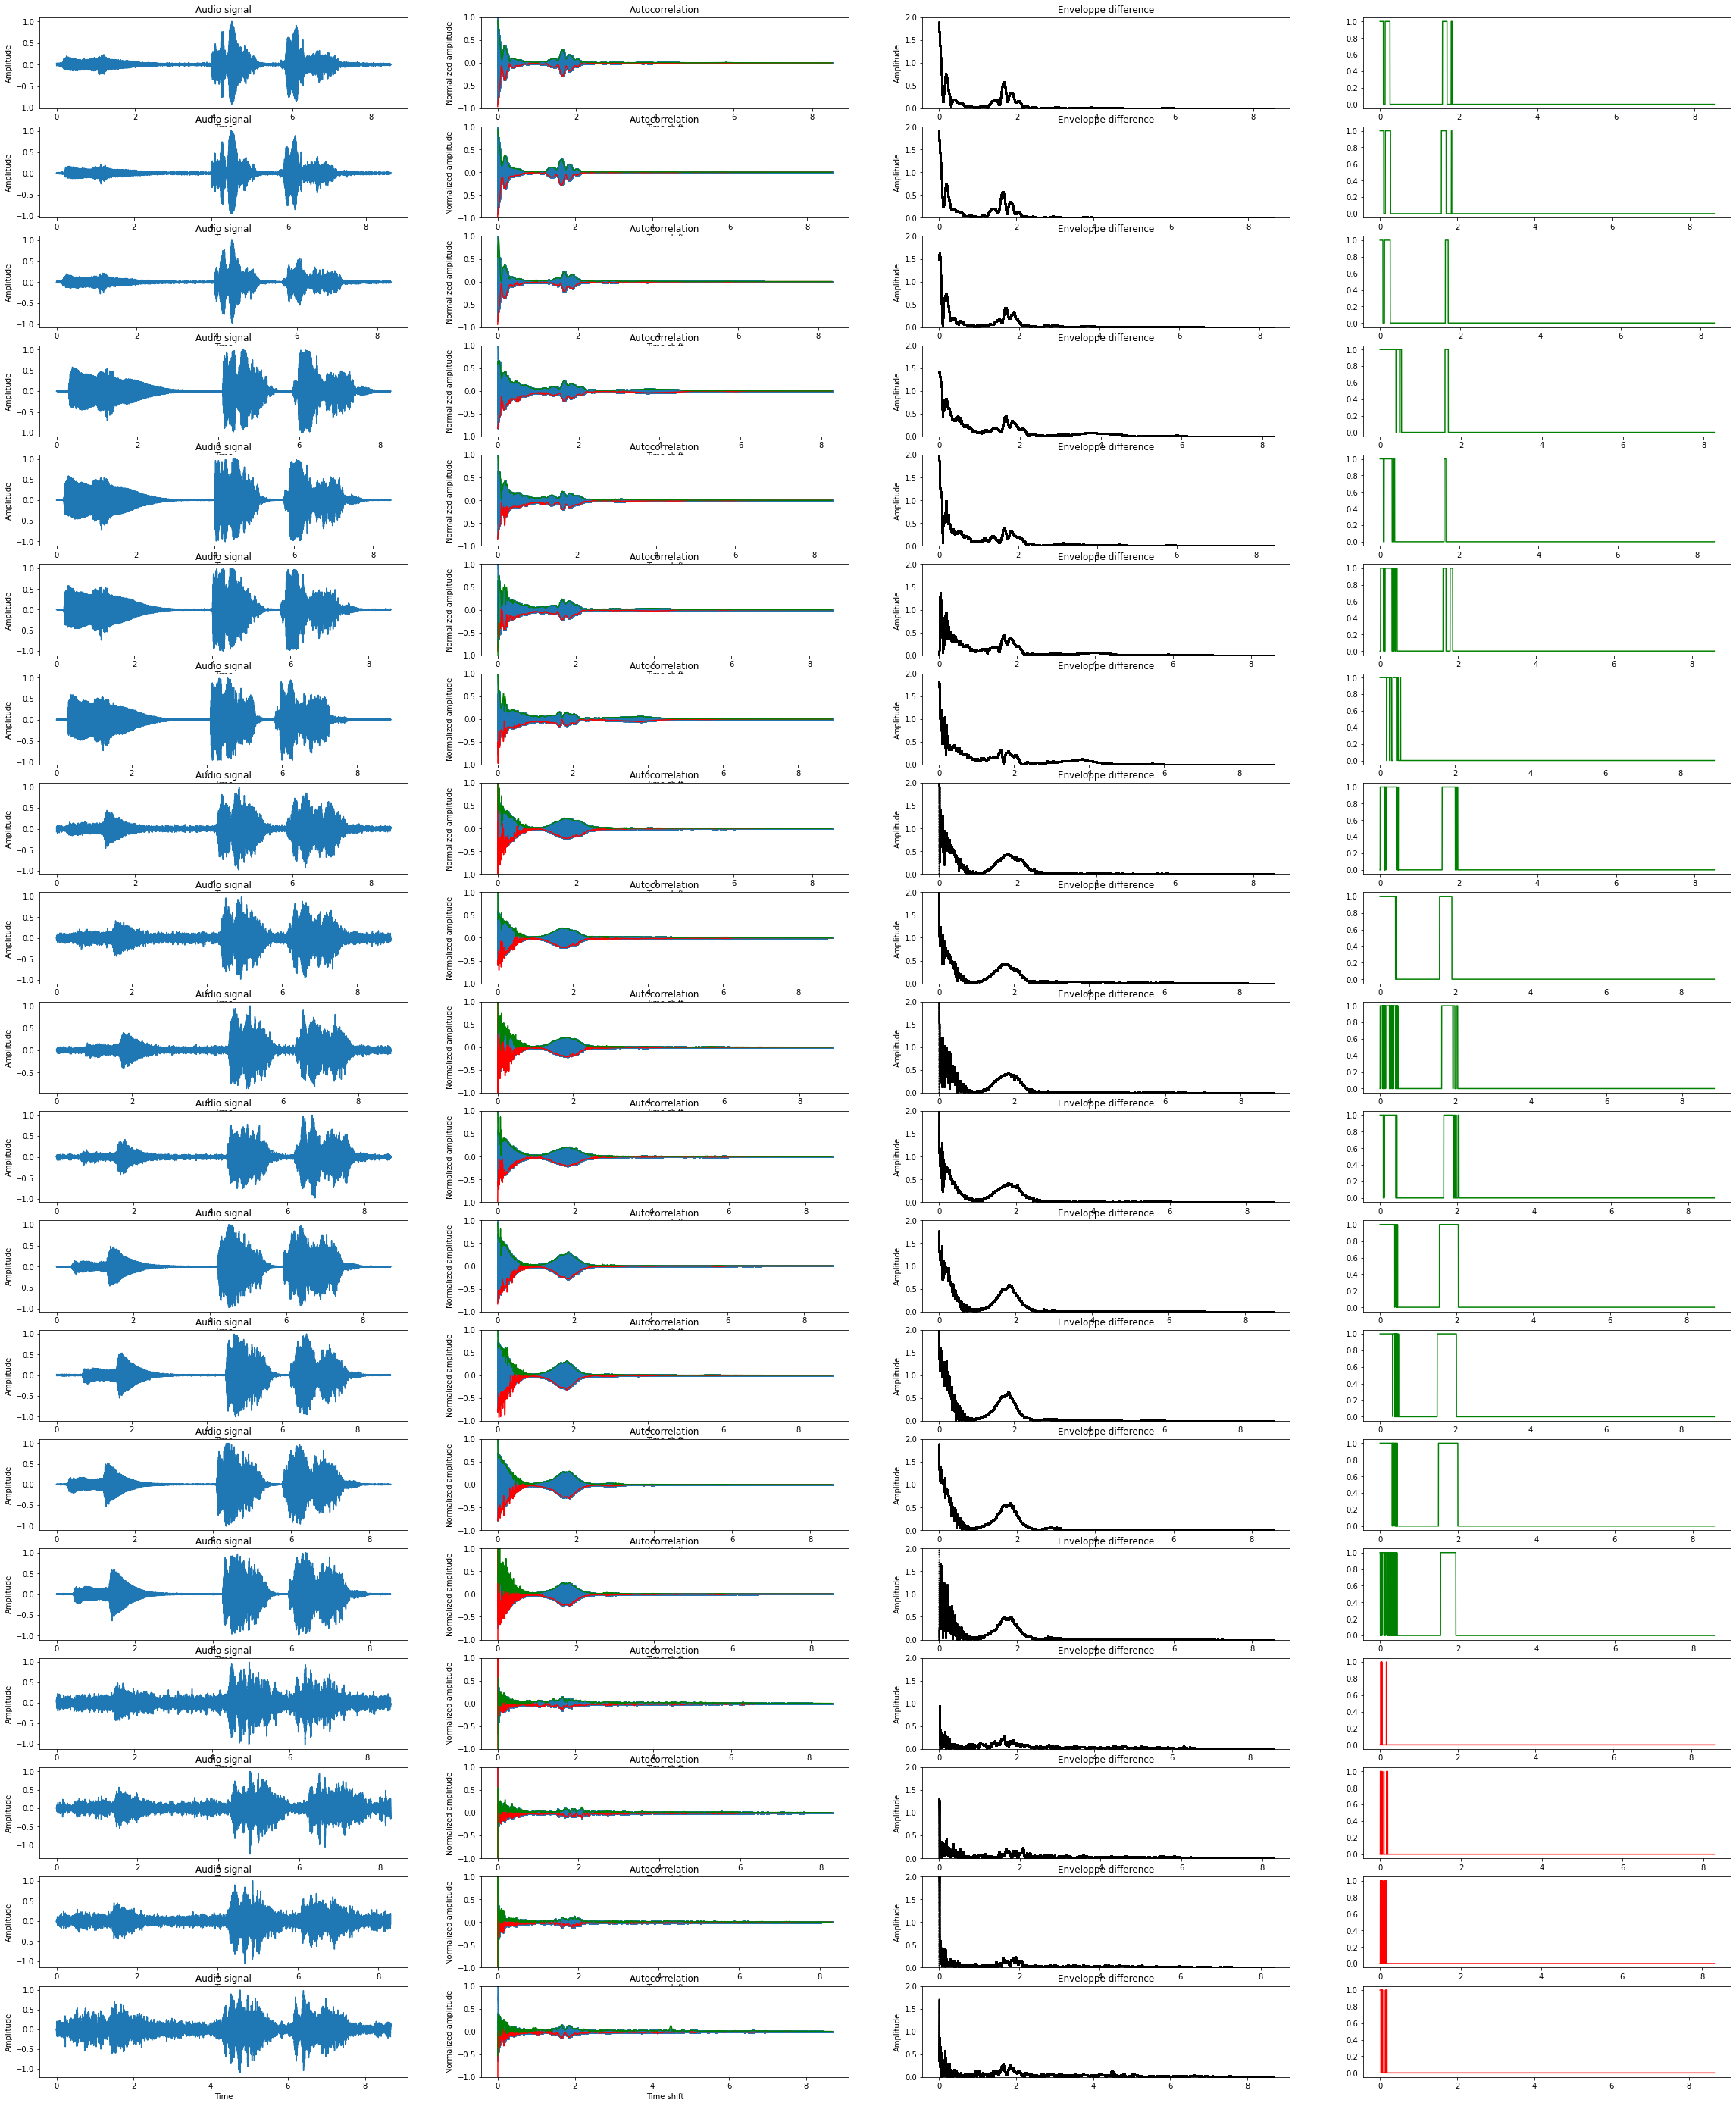

In [ ]:
plt.rcParams["figure.figsize"] = (40,50)
count=[]
#files = [f"/content/drive/My Drive/experiments_AURA/{i}.wav" for i in ["indoor", "outdoor"]]

for i in range(len(files)):
  time, audio = get_audio_file(files[i], 2)

  plt.subplot(len(files), 4, 4*i+1)
  plt.plot(time, audio)
  plt.title('Audio signal')
  plt.ylabel('Amplitude')
  plt.xlabel("Time")

  autocorr = normalized_autocor(audio)
  low_enveloppe, high_enveloppe = get_envelopes_interpolated(autocorr)
  
  plt.subplot(len(files), 4, 4*i+2)
  plt.scatter(time[:len(autocorr)], autocorr, s=1)

  plt.plot(np.array(time), low_enveloppe(time), color='red')
  plt.plot(np.array(time), high_enveloppe(time), color='green')
  plt.title('Autocorrelation')
  plt.ylabel('Normalized amplitude')
  plt.xlabel("Time shift")
  plt.ylim((-1,1))

  env_diff = high_enveloppe(time)-low_enveloppe(time)
  plt.subplot(len(files), 4, 4*i+3)
  plt.scatter(time, env_diff, color='black', s=1)
  plt.title('Enveloppe difference')
  plt.ylabel('Amplitude')
  plt.ylim((0,2))

  thresholded = threshold(env_diff, 0.35)
  count.append(np.count_nonzero(thresholded))
  if count[-1] > 10000:
    colorrr = "green"
  else:
    colorrr = "red"
  plt.subplot(len(files), 4, 4*i+4)
  plt.plot(time, thresholded, color=colorrr)
  

In [ ]:
count

[16821,
 17553,
 13734,
 28414,
 16986,
 22996,
 20190,
 37722,
 36106,
 36096,
 35025,
 44389,
 45007,
 43005,
 32414,
 871,
 994,
 1666,
 2713]

# Threshold

In [ ]:
thresholds = list(set([5*i/100 for i in range(21)] + [i/100 for i in range(25, 60)]))
thresholds.sort()
truth = np.array([True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False])

In [ ]:
def threshold(array, limit):
  a = np.array(array, copy=True)  
  a[a >= limit] = 1
  a[a <  limit] = 0
  return a

y = []
fp = []
tp = []
fn = []
tn = []

CUSTOM_ENVELOPE = True

for thresh in thresholds:
  files = [f"/content/drive/My Drive/experiments_AURA/audio_{i:03d}.wav" for i in range(2, 21)]
  prediction = []
  for i in range(len(files)):
    ifile = wave.open(files[i])
    samples = 2*ifile.getnframes()
    frequency = ifile.getframerate()
    audio = ifile.readframes(samples)

    # Convert buffer to float32 using NumPy                                                                                 
    audio_as_np_int16 = numpy.frombuffer(audio, dtype=numpy.int16)
    audio_as_np_float32 = audio_as_np_int16.astype(numpy.float32)

    # Normalise float32 array so that values are between -1.0 and +1.0                                                      
    max_int16 = 2**15

    time = [i/frequency for i in range(samples)]
    audio_normalised = audio_as_np_float32 / max_int16
    #audio_normalised = audio_normalised / max(audio_normalised)
    
    a = autocorrellation(audio_normalised)
    a = a[len(a)//2:]
    a = a / a[0]

    if CUSTOM_ENVELOPE:
      low_enveloppe, high_enveloppe = hl_envelopes_idx(a)
      low_enveloppe = interp1d(np.array(time)[low_enveloppe], a[low_enveloppe], kind="cubic", fill_value="extrapolate")
      high_enveloppe = interp1d(np.array(time)[high_enveloppe], a[high_enveloppe], kind="cubic", fill_value="extrapolate")
      b = threshold((high_enveloppe(time)-low_enveloppe(time))[1000:], thresh)
    else:
      analytic_signal = hilbert(a)
      amplitude_envelope = np.abs(analytic_signal)
      #plt.plot(np.array(time[:len(a)]), amplitude_envelope, color="orange")
      b = threshold(amplitude_envelope[1000:], thresh)
    
    count = np.count_nonzero(b)
    prediction.append(count > 5000)
  tn_v, fp_v, fn_v, tp_v = confusion_matrix(truth, np.array(prediction)).ravel()
  fp.append(fp_v)
  tp.append(tp_v)
  fn.append(fn_v)
  tn.append(tn_v)
  """c = np.array(prediction) == truth
  y.append(np.count_nonzero(c)/len(c))"""



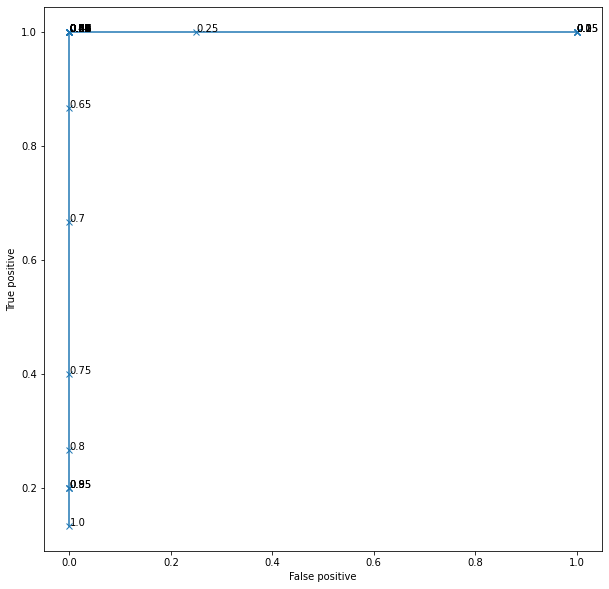

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)

fp=np.array(fp)
tp=np.array(tp)
fn=np.array(fn)
tn=np.array(tn)

tpr = tp / (tp+fn)
fpr = fp / (tn+fp)

plt.plot(fpr, tpr, marker="x")
for i, txt in enumerate(thresholds):
    plt.annotate(txt, (fpr[i], tpr[i]))
plt.ylabel('True positive')
plt.xlabel('False positive')
plt.show()

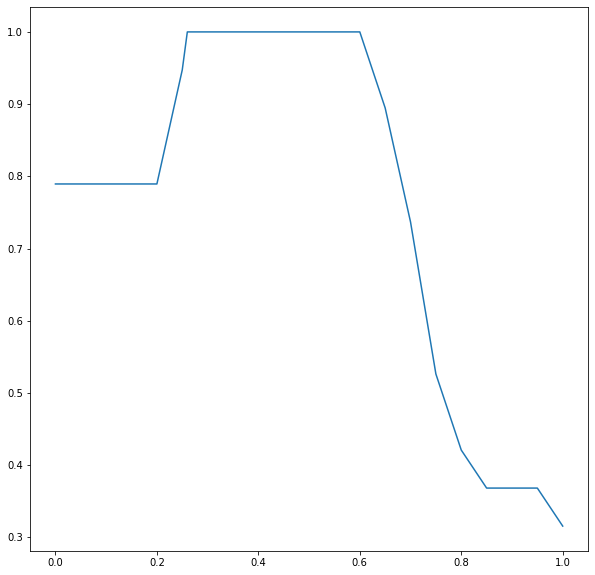

In [ ]:
plt.plot(thresholds, (tp+tn)/(tp+tn+fp+fn))

# Sliding window (Failure)

In [ ]:
audio_normalised.shape

In [ ]:
WINDOW_SIZE = 408258//8
WINDOW_STRIDE = 408258//12


In [ ]:
windows = [a for a in get_sliding_windows(audio_normalised, WINDOW_SIZE, WINDOW_STRIDE) if len(a)==WINDOW_SIZE]

In [ ]:
len(windows)

In [ ]:
seq = random.choice(windows)

In [ ]:
seq.shape

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)

for i in range(len(windows)):
  a = autocorrellation(windows[i])

  a = a[len(a)//2:]
  """analytic_signal = hilbert(a)
  amplitude_envelope = np.abs(analytic_signal)"""

  #f2 = interp1d(time[:len(a)], amplitude_envelope, kind='cubic')
  #peaks, _ = find_peaks(amplitude_envelope, prominence=1)
  """analytic_signal = hilbert(amplitude_envelope)
  amplitude_envelope = np.abs(analytic_signal)"""

  low_enveloppe, high_enveloppe = hl_envelopes_idx(a)
  low_enveloppe = interp1d(np.array(time)[low_enveloppe], a[low_enveloppe], kind="cubic", fill_value="extrapolate")
  high_enveloppe = interp1d(np.array(time)[high_enveloppe], a[high_enveloppe], kind="cubic", fill_value="extrapolate")
  plt.subplot(4, 4, i+1)
  plt.scatter(time[:len(a)], a, s=1)

  #plt.plot(np.array(time), low_enveloppe(time), label='nearest', color='red')
  #plt.plot(np.array(time), high_enveloppe(time), label='nearest', color='green')

  #plt.plot(np.array(time), high_enveloppe(time)-low_enveloppe(time), label='nearest', color='black')

  #plt.plot(time[:len(a)], f2(time[:len(a)]), label='envelope', color='red')
  #plt.plot(np.array(time[:len(a)]), amplitude_envelope, color="orange")
  plt.title('Autocorelation')
  plt.ylabel('Amplitude')


# Some tests about sliding windows

In [ ]:
size = 3
step = 2
A = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
A = [A[i : i + size] for i in range(0, len(A), step)]

In [ ]:
def get_sliding_windows(array, size=3, step=2):
    return [array[i : i + size] for i in range(0, len(array), step)]

In [ ]:
A = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
get_sliding_windows(A, 10)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [3, 4, 5, 6, 7, 8, 9, 10],
 [5, 6, 7, 8, 9, 10],
 [7, 8, 9, 10],
 [9, 10]]